In [1]:
# IMPORT MODULES

import numpy as np
from numpy import ma
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

2022-12-05 10:58:26.286116: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dfRaw = pd.read_csv('creditcard.csv')
print(dfRaw.shape)
print(dfRaw.columns)

(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [3]:
#  SCALER / Normalization

data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

data  (284807, 31)
normal_data  (284315, 31)
fraud_data  (492, 31)
Percent fraud  0.1727 %


In [16]:
# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 20000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
#print("X_valid ", X_valid.shape)
#print("y_valid ", y_valid.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

KeyError: "['time', 'class', 'amount'] not found in axis"

In [5]:
X_inliers = shuffled_data[-num_test:]
X_outliers = fraud_pca_data[:]
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

PercFraud = n_outliers / X_test.shape[0]
PercFraud

print('X_inliers ', X_inliers.shape)
print('X_outliers ', X_outliers.shape)
print('X ', X.shape)
print('n_outliers ', n_outliers)
print('percent fraud in test: ', PercFraud)

X_inliers  (20000, 30)
X_outliers  (492, 30)
X  (20492, 30)
n_outliers  492
percent fraud in test:  0.024009369510052704


In [6]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination = PercFraud)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
print(X_scores)
n_errors

[-1.1766108  -1.4434325  -1.26030612 ... -1.03791898 -1.09955275
 -1.08083583]


934

In [7]:
print('accuracy ' , round(1 - (n_errors / X.shape[0]),4))


accuracy  0.9544


In [8]:
# Note that the ground truth and the y_pred for LOF is different than the original ... inliers = normal = 1 and outliers = fraud = -1
# We have to modify the y_pred for the F1 score calculation to be similar to the above 

y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)
print(y_predDF[y_predDF[0] == -1].count())

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1
print(y_predDF[y_predDF[0] == 1].count())

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)

0    492
dtype: int64
0    492
dtype: int64


In [9]:
# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.0508
recall  0.0508
F1 score on Test 0.0508


In [10]:
# Optimize num of neighbors hyper paramter for best F1

minRE = 500
maxRE = 1100
    
EpsF1 = []

for TryRE in range(minRE,maxRE,100):
    clf = LocalOutlierFactor(n_neighbors=TryRE, contamination = PercFraud)
    y_pred = clf.fit_predict(X)
    n_errors = (y_pred != ground_truth).sum()
    X_scores = clf.negative_outlier_factor_
    
    y_predLOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predLOF)
    
    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1
    
    y_predLOF = y_predDF.values
    y_predLOF = np.ravel(y_predLOF)
    
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
    
    print("F1 score on test", round(fbeta_score,4), " with num neighbors ", TryRE)
    EpsF1.append([TryRE, round(fbeta_score,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['NumNeighb', 'F1'])
EpsF1df.head()

F1 score on test 0.561  with num neighbors  500
F1 score on test 0.5915  with num neighbors  600
F1 score on test 0.6037  with num neighbors  700
F1 score on test 0.6098  with num neighbors  800
F1 score on test 0.6138  with num neighbors  900
F1 score on test 0.6037  with num neighbors  1000


,NumNeighb,F1
0,500,0.5610
1,600,0.5915
2,700,0.6037
3,800,0.6098
4,900,0.6138


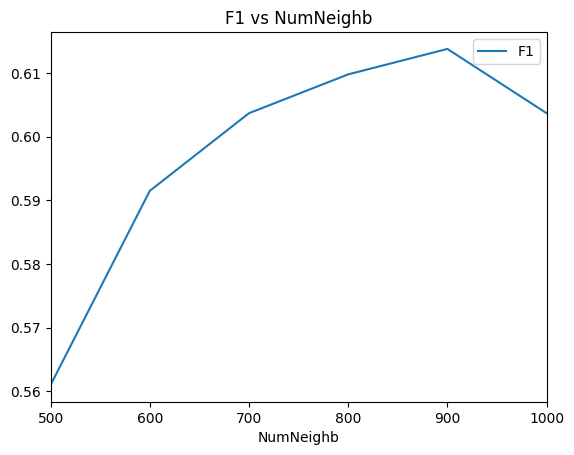

In [11]:
EpsF1df.plot.line("NumNeighb","F1")
plt.xlim(500, 1000)
plt.title("F1 vs NumNeighb")
plt.show()

# Whole dataset

In [12]:
data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

# CREATE the TRAIN and TEST sets
# Fraud data is ONLY in TEST - not in TRAIN

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
#print("X_valid ", X_valid.shape)
#print("y_valid ", y_valid.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

X_inliers = shuffled_data[-num_test:]
X_outliers = fraud_pca_data[:]
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

PercFraud = n_outliers / X_test.shape[0]
PercFraud

print('X_inliers ', X_inliers.shape)
print('X_outliers ', X_outliers.shape)
print('X ', X.shape)
print('n_outliers ', n_outliers)
print('percent fraud in test: ', PercFraud)

data  (284807, 31)
normal_data  (284315, 31)
fraud_data  (492, 31)
Percent fraud  0.1727 %
normal_pca_data  (284315, 30)
fraud_pca_data (492, 30)
Fraud data only in Test with NONE in the training
X_train  (209315, 30)
X_test  (75492, 30)
y_test  (75492,)
X_inliers  (75000, 30)
X_outliers  (492, 30)
X  (75492, 30)
n_outliers  492
percent fraud in test:  0.0065172468605945


In [13]:
clf = LocalOutlierFactor(n_neighbors=900, contamination = PercFraud)

y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
#print('accuracy ' , round(1 - (n_errors / X.shape[0]),4))

In [14]:
n_errors

420

In [15]:
y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)

# F1 Score
#print("F1 score", round(f1_score(y_valid,pred, average='binary'), 4))
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
print("precision ", round((precision), 4))
print("recall ", round((recall), 4))
print("F1 score on Test", round((fbeta_score), 4))

precision  0.5732
recall  0.5732
F1 score on Test 0.5732
